# Visibilities and Fringe Patterns

Here, we try to put the final pieces together for understanding the output of a correlator, which is a quantity we call the **visibility**.  Previously, we've seen how two antennas on the ground each recieve a time-shifted
version of the (noisy) electric field signal coming from some astrophysical source. We also learned that we
could use a **correlation** to extract the shifted signal from the voltage timestreams of the two antennas, allowing us to report a power as a function of delay:
\begin{equation}
\left[v_1\star v_2\right](\tau) \equiv \int{v_1(t)v_2^*(t-\tau)dt}.
\end{equation}

We also saw that this correlation is related to the product of the Fourier transforms of the two signals:
\begin{equation}
\left[v_1\star v2\right](\tau) = \frac1{2\pi}\int{\tilde v_1(\nu)\tilde v_2^*(\nu) e^{2\pi i\nu\tau}d\nu}.
\end{equation}
What if we don't do this last Fourier transform?  Let's define the **visibility** as:
\begin{equation}
V_{12}(\vec b, \nu) \equiv \tilde v_1(\nu)\, \tilde v_2^*(\nu).
\end{equation}

It turns out that the visibility can be related to the distribution of brightness on the sky by the **measurement equation for interferometers**:
\begin{equation}
V(\vec b, \nu) = \int\!\!\int{A_\nu(\hat s)\, I_\nu(\hat s)\, e^{2\pi i \nu\frac{\vec b\cdot \hat s}{c}} d\Omega},
\end{equation}
where $A(\hat s)$ is the beam response in direction $\hat s$, $I$ is the specific intensity 
(brightness per frequency), $\vec b$ is the baseline vector, and $c$ is the speed of light.  You'll recognize that $\frac{\vec b\cdot \hat s}{c}$ is an expression of the **geometric delay** of a signal coming from direction $\hat s$. All this equation is doing is adding up all the power contained in all the electric fields coming from all directions on the sky, each with their proper geometric delay.

Now, since visibilities are per-frequency quantities, we would like to see how an interferometer works at just one frequency. In particular, we'd like to visualize the **fringe pattern**, which is the component inside the integral of the measurement equation that looks like:
\begin{equation}
e^{2\pi i \nu\frac{\vec b\cdot \hat s}{c}}.
\end{equation}

We are super interested in the fringe pattern because it turns out to look like (but not _exactly_ like) a sinusoid in angle across the sky. As a result, the visibility turns out to be, to a very good approximation, **a measurement of the 2D Fourier tranform of the distribution of brightness on the sky.** 

## Simulation

In the simulation below, we visualize the direction-dependent phase that an incoming sine wave picks up as a result of the geometric separation between two antennas. This direction-dependent phase is call the fringe pattern of a baseline and is a very powerful way of understanding the response of an interferometer.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, FloatSlider, Layout

In [3]:
# High-level parameters
SIZE = 256     # number of points in each line
RMAX = 3      # radius of simulation (i.e. length of each line)
NSTEPS = 300   # number of cycles in simulation before repeat
FREQ = 30.0

# Variables derived from parameters above
xs = np.linspace(0, RMAX, SIZE)
radiation = (xs, np.exp(2j*np.pi*FREQ*np.linspace(0,1,SIZE))) # x,y coordinates of E field

def update_radiation(t):
    """Launch photon wavelets along each line, propagating radially outward 
    at one index per simulation cycle."""
    radiation[1][:-1] = radiation[1][1:] #  propagate radiation inward
    radiation[1][-1] = np.exp(2j*np.pi*FREQ*t) # put new noise at end
    

angles = np.linspace(0, np.pi, SIZE)
response = np.exp(-(angles-np.pi/2)**2/2)

freqs = np.fft.fftfreq(SIZE)
signal1 = np.zeros(SIZE, dtype=np.complex)
signal2 = np.zeros(SIZE, dtype=np.complex)

def update_signal(radiation, baseline, angle):
    global signal1, signal2
    signal1[1:] = signal1[:-1] # shift right
    signal2[1:] = signal2[:-1] # shift right
    if np.cos(angle) < 0:
        signal1[0] = radiation[0]
        signal2[0] = np.fft.fft(np.fft.ifft(radiation) * np.exp(2j*np.pi*baseline*np.cos(angle)*freqs))[0]
    else:
        signal2[0] = radiation[0]
        signal1[0] = np.fft.fft(np.fft.ifft(radiation) * np.exp(-2j*np.pi*baseline*np.cos(angle)*freqs))[0]

<IPython.core.display.Javascript object>


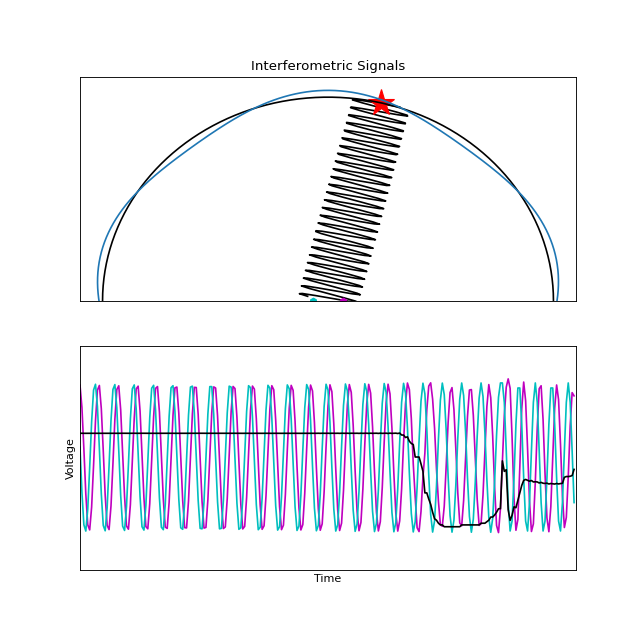

interactive(children=(FloatSlider(value=1.5707963267948966, description='Hour Angle [radians]', layout=Layout(…

In [5]:
# Generate the animation figure

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
#fig, ax1 = plt.subplots(1, figsize=(8,4))
x, y = radiation
line, = ax1.plot(x, y.real, 'k') # holds handle for incoming radiation
source, = ax1.plot([0], [RMAX], 'r*', markersize=25) # holds handle for plotting radiating source
#beam, = ax1.plot(np.cos(angles)*response, np.sin(angles)*response, 'b')
circle, = ax1.plot(RMAX*np.cos(angles), RMAX*np.sin(angles), 'k')
scalar = 10*FREQ / SIZE/2
fringe_r, = ax1.plot(np.cos(angles) * (RMAX + 0.1*np.cos(-np.linspace(-np.pi/2,np.pi/2,SIZE)*10 * scalar)), 
                     np.sin(angles) * (RMAX + 0.1*np.cos(-np.linspace(-np.pi/2,np.pi/2,SIZE)*10 * scalar)))
ant1, = ax1.plot([-5/20], [0], 'ch')
ant2, = ax1.plot([5/20], [0], 'mh')
antenna1, = ax2.plot(signal1.real, 'm')
antenna2, = ax2.plot(signal2.real, 'c')
corr, = ax2.plot(np.real(signal1 * signal2.conj()), 'k')

# Slider controlling frequency of charge oscillation
angle_widget = FloatSlider(np.pi/2, min=0, max=np.pi, step=0.01,
                           description='Hour Angle [radians]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))
baseline_widget = FloatSlider(10, min=0, max=20.0, step=0.5,
                           description='Baseline Separation [m]',
                           style={'description_width':'initial'},
                           layout=Layout(width='auto', grid_area='footer'))

def animate(t):
    '''Update plots for each line according to the time step. Reads theta
    from theta_widget. Called repeatedly by FuncAnimation.'''
    th = np.pi - angle_widget.value
    baseline = baseline_widget.value
    amp = 0.4
    sig = radiation[1][0] * response[np.argmin(np.abs(angles - th))]
    update_signal(radiation[1], baseline, th)
    antenna1.set_ydata(signal1.real)
    antenna2.set_ydata(signal2.real)
    corr.set_ydata(np.real(signal1 * signal2.conj()))
    update_radiation(t)
    x, y = radiation
    plot_x = np.cos(th) * x - np.sin(th) * y * amp
    plot_y = np.sin(th) * x + np.cos(th) * y * amp
    line.set_xdata(plot_x)
    line.set_ydata(plot_y)
    source.set_xdata([RMAX * np.cos(th)])
    source.set_ydata([RMAX * np.sin(th)])
    fringe_r.set_xdata(np.cos(angles) * (RMAX + 0.1*np.cos(-np.linspace(-np.pi/2,np.pi/2,SIZE)*baseline * scalar)))
    fringe_r.set_ydata(np.sin(angles) * (RMAX + 0.1*np.cos(-np.linspace(-np.pi/2,np.pi/2,SIZE)*baseline * scalar)))
    ant1.set_xdata([-baseline/40])
    ant2.set_xdata([+baseline/40])
    
    
def init():
    '''Set initial plot parameters. Called once by FuncAnimation at beginning.'''
    ax1.set_xlim(-1.1*RMAX,1.1*RMAX)
    ax1.set_ylim(0,1.1*RMAX)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.set_ylim(-1.5,1.5)
    ax2.set_xlim(0, SIZE)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_ylabel('Voltage')
    ax2.set_xlabel('Time')
    ax1.set_title('Interferometric Signals')
    
steps = np.linspace(0, 1, NSTEPS) # simulation interval
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=True)

def build_animation(angle, baseline):
    '''Function which causes FuncAnimation to redraw itself, when freq_widget changes.
    Does not actually hand off the value, but needs to accept an argument tied to
    freq_widget in order to be triggered by updating the slider.'''
    ani.new_frame_seq()

# force animation to redraw when freq_widget changes, even though
# the parameter is not actually passed through (used as global, instead)
interact(build_animation, angle=angle_widget, baseline=baseline_widget)
plt.show()